In [24]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from src.PDE_Solver import PDESolver_nd
from src.solver_2d import false_transient_one_iteration_python
from src.derivative import derivatives_2d, derivative_1d

from src.supportfunctions import finiteDiff, PDESolver_2d
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300

In [58]:
# parameters
delta        = 0.01
eta          = 0.032
xi_a         = 0.01
theta_list   = pd.read_csv("../ClimateUncertaintySpillover_ov/data/model144.csv", header=None)[0].to_numpy()
theta_list   = theta_list/1000
theta = np.mean(theta_list)
sigma_y = 1.2 * theta
# damage function
y_bar        = 2
gamma_1      = 0.00017675
gamma_2      = 2*0.0022
gamma_3_list = np.linspace(0., 1./3, 20)
gamma_3=0
# y grid
# λ = np.log(2)/6
lambda0     = np.log(2)/6

In [59]:
#Discretization of the State Space
y1_step = .04
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat)= np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace      = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])

hy1  = y1_grid[1] - y1_grid[0]
hy2  = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [60]:
#Hypyerparmaters
tol = 1e-7
epsilon = .01
#Similar Function to the One found in Suri's Notebook
def solve_prep(y1_mat, y2_mat, gamma_3, tol=1e-7, ϵ=1, max_iter=2000, fraction=0.05): 
    #Define Intial Guess values
    V_new =  - eta*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
    lhs_error = 0.5
    count = 0
    E_new = eta*np.ones(y1_mat.shape)
    E_old = E_new
    E = E_new
    pi_ao = np.ones((len(theta_list), n_y1, n_y2))/len(theta_list)
    theta_mat = np.zeros((len(theta_list), n_y1, n_y2))
    for i in range(len(theta_list)):
        theta_mat[i] = theta_list[i]
    pi_a = pi_ao
    log_prob_ratio = np.zeros_like(theta_mat)
    while lhs_error > tol and count < max_iter:
        if count ==0:
            V =  - eta*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = V.copy()
        #Apply Finite Difference 
        dVdy1 = finiteDiff(V, 0,1,hy1)
        dVdy2 = finiteDiff(V, 1,1,hy2)
        #Solve for the probabilities first
        weight = np.array([-1/xi_a*dVdy2*lambda0*E*theta for theta in theta_list])
        weight = weight - np.max(weight, axis=0)
        pi_a = pi_ao*np.exp(weight)
        pi_a[pi_a<1e-15] = 1e-15
        pi_a = pi_a/np.sum(pi_a, axis=0)
        #Solve for the Emissions next
        E_new =  - eta/(dVdy2*lambda0*np.sum(theta_mat*pi_a, axis=0))
        E_new[E_new <= 1e-15] = 1e-15
        E = E_new*fraction + E_old*(1 - fraction)
        #Use Above to compute the Coeffecients
        #Computation of the Coeffecients 
        A = np.ones_like(y1_mat)*(-delta)
        B_y1 = y2_mat
        B_y2 = (-y2_mat + np.sum(theta_mat*pi_a,axis=0)*E)*lambda0
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = (eta-1)/delta \
                * (gamma_1+gamma_2*y1_mat + gamma_3*(y1_mat-y_bar)*(y1_mat>y_bar))*y2_mat\
                +np.log(E)*eta \
                + xi_a*np.sum(pi_a*(np.log(pi_a)-np.log(pi_ao)), axis=0)
        #Use Coefficients as inputs of the PDESolver
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, V, epsilon, solverType = 'False Transient')
        #Outputs and Errors of the code
        out_comp = out[2].reshape(V.shape,order = "F")
        rhs = A*V + B_y1*dVdy1 + B_y2*dVdy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - V)/epsilon))
        count = count+ 1
        V = out_comp
        E_old = E
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(count, rhs_error, lhs_error, out[0], out[1]))
    result = dict(E=E, V=V_new, pi_a=pi_a)
    return result 

In [61]:
res_list = {}
i=0
for gamma_3_i in gamma_3_list:
    safe = solve_prep(y1_mat, y2_mat, gamma_3_i, 1e-6, 0.001, 2000, 0.05)
    res_list[i]  = safe
    i=i+1

Episode 2000: PDE Error: 0.060716252229; False Transient Error: 0.060699897672; Iterations: 6; CG Error: 0.000000000009
Episode 2000: PDE Error: 0.060716248880; False Transient Error: 0.060699894496; Iterations: 6; CG Error: 0.000000000008
Episode 2000: PDE Error: 0.060716247129; False Transient Error: 0.060699892581; Iterations: 6; CG Error: 0.000000000007
Episode 2000: PDE Error: 0.073392703383; False Transient Error: 0.073325178611; Iterations: 5; CG Error: 0.000000000091
Episode 2000: PDE Error: 0.095820508996; False Transient Error: 0.095732676374; Iterations: 5; CG Error: 0.000000000081
Episode 2000: PDE Error: 0.116958676342; False Transient Error: 0.116850683348; Iterations: 5; CG Error: 0.000000000073
Episode 2000: PDE Error: 0.137237145583; False Transient Error: 0.137109089493; Iterations: 5; CG Error: 0.000000000067
Episode 2000: PDE Error: 0.156901094289; False Transient Error: 0.156753043652; Iterations: 5; CG Error: 0.000000000062
Episode 2000: PDE Error: 0.176103717859;

In [62]:
ϕ_list = np.zeros((len(gamma_3_list), len(y1_grid), len(y2_grid)))
ems_list = np.zeros((len(gamma_3_list), len(y1_grid), len(y2_grid)))
for j in range(len(gamma_3_list)):
    ϕ_list[j] = res_list[j]['V']
    ems_list[j] = res_list[j]['E']

np.save("v_list_2", ϕ_list)
np.save("e_list_2", ems_list)

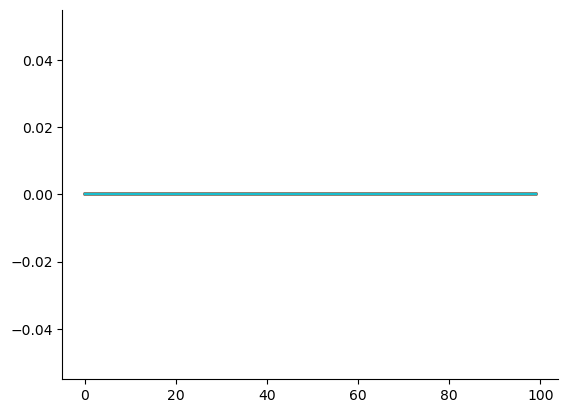

In [80]:
loc_start = np.abs(y2_grid - np.mean(theta_list)).argmin()
loc_twi = np.abs(y2_grid - 2 * np.mean(theta_list)).argmin()
loc_tri = np.abs(y2_grid - 3 * np.mean(theta_list)).argmin()
plt.plot(ϕ_list[0])
plt.show()

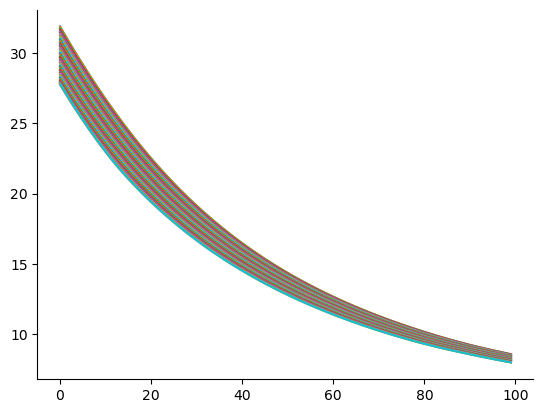

In [81]:
plt.plot(ems_list[0])
# plt.ylim(-6,6)
plt.show()


In [65]:
y1_grid_cap = np.arange(0., 2.1 + y1_step, y1_step)
loc_2 = np.abs(y1_grid - 2.).argmin()
xi_p = 1
epsilon = 0.1
max_iter = 2000
dmg_weight = np.ones(len(gamma_3_list)) / len(gamma_3_list)
ϕ_list = np.zeros((len(gamma_3_list), len(y1_grid), len(y2_grid)))
ϕ_weight = np.average(np.exp(-1 / xi_p * ϕ_list), axis=0, weights=dmg_weight)

ϕ_equiv = -xi_p * np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
pi_do = np.ones((len(gamma_3_list), num_y1, num_y2)) / len(gamma_3_list)
pi_ao = np.ones((len(theta_list), num_y1, num_y2)) / len(theta_list)
theta_mat = np.zeros((len(theta_list), num_y1, num_y2))
for i in range(len(theta_list)):
    theta_mat[i] = theta_list[i]
DF1 = gamma_1 + gamma_2 * y1_mat_cap

r1 = 1.5
r2 = 2.5
y_lower = 1.5
Intensity = r1 * (np.exp(r2 / 2 * (y1_mat_cap - y_lower)**2) -
                  1) * (y1_mat_cap >= y_lower)



In [66]:
# initiate v and control
tol = 1e-6
E = eta
E_old = E
lhs_error = 1
count = 0
fraction=0.05
V = ϕ_equiv[:num_y1]
V_m = np.zeros(pi_do.shape)
log_prob_ratio = np.zeros_like(theta_mat)
for i in range(len(gamma_3_list)):
    V_m[i] = ϕ_list[i][loc_2]

In [67]:
while lhs_error > tol and count < max_iter:
    V0_old = V.copy()
    dVdy1 = derivatives_2d(V, 0,1,hy1)
    dVdy2 = derivatives_2d(V, 1,1,hy2)
    #computation of controls using backwards and forward difference
    weight = np.array([-1/xi_a * dVdy2 * lambda0 * E_old * theta for theta in theta_list])
    weight = weight - np.max(weight, axis=0)
    pi_a = pi_ao*np.exp(weight)
    pi_a[pi_a<1e-15] = 1e-15
    pi_a = pi_a/np.sum(pi_a, axis=0) 
    E_new =  - eta/(dVdy2*lambda0*np.sum(theta_mat*pi_a, axis=0))
    E_new[E_new <= 1e-15] = 1e-15
    E = E_new*fraction + E_old*(1 - fraction)
    E[E <= 1e-10] = 1e-10
    # updating controls
    #     print(np.min(ems))
    g_m = np.exp(1 / xi_p * (V - V_m))
    # HJB coefficient
    A = np.ones_like(y1_mat_cap)*(-delta)- Intensity * np.sum(pi_do * g_m, axis=0)
    B_y1 = y2_mat_cap
    B_y2 = (-y2_mat_cap + np.sum(theta_mat*pi_a,axis=0)*E)*lambda0
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = (eta-1)/delta \
      * DF1*y2_mat_cap\
      +np.log(E)*eta \
      + xi_a*np.sum(pi_a*(np.log(pi_a)-np.log(pi_ao)), axis=0)\
      + Intensity * np.sum(pi_do * g_m * V_m, axis=0)\
      + xi_p * Intensity * np.sum(pi_do*(1-g_m+g_m * np.log(g_m)), axis=0)
    phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        V,
        epsilon,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))

    rhs = A * phi_mat + B_y1 * dVdy1 + B_y2 * dVdy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat - V) / epsilon))
    V = phi_mat
    E_old = E
    count += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(count, lhs_error, rhs_error))

<ipython-input-67-eabe1df1db24>:11: RuntimeWarning: divide by zero encountered in true_divide
  E_new =  - eta/(dVdy2*lambda0*np.sum(theta_mat*pi_a, axis=0))


Episode: 1	 lhs error: 0.146999361850	 rhs error: 0.147450398404
Episode: 2	 lhs error: 0.253815319901	 rhs error: 0.266654175762
Episode: 3	 lhs error: 0.243147608063	 rhs error: 0.253881491752
Episode: 4	 lhs error: 0.233471691247	 rhs error: 0.242640934025
Episode: 5	 lhs error: 0.225018263647	 rhs error: 0.233171155018
Episode: 6	 lhs error: 0.217448030706	 rhs error: 0.225037589659
Episode: 7	 lhs error: 0.210411338279	 rhs error: 0.217932826468
Episode: 8	 lhs error: 0.203653890141	 rhs error: 0.210780594510
Episode: 9	 lhs error: 0.197045059154	 rhs error: 0.204315481623
Episode: 10	 lhs error: 0.190515462967	 rhs error: 0.198137425754
Episode: 11	 lhs error: 0.184079324029	 rhs error: 0.192180445784
Episode: 12	 lhs error: 0.177718622918	 rhs error: 0.185629749625
Episode: 13	 lhs error: 0.171542114928	 rhs error: 0.180139880757
Episode: 14	 lhs error: 0.165491510162	 rhs error: 0.173596005156
Episode: 15	 lhs error: 0.159684449721	 rhs error: 0.168052635351
Episode: 16	 lhs er

Episode: 126	 lhs error: 0.087915187348	 rhs error: 0.088521366672
Episode: 127	 lhs error: 0.087592517639	 rhs error: 0.088169813797
Episode: 128	 lhs error: 0.087253576857	 rhs error: 0.087818560991
Episode: 129	 lhs error: 0.086896029506	 rhs error: 0.087487265110
Episode: 130	 lhs error: 0.086540980800	 rhs error: 0.087102292851
Episode: 131	 lhs error: 0.086198136801	 rhs error: 0.086740765542
Episode: 132	 lhs error: 0.085833831787	 rhs error: 0.086386937095
Episode: 133	 lhs error: 0.085507458795	 rhs error: 0.086010070993
Episode: 134	 lhs error: 0.085153845346	 rhs error: 0.085678403811
Episode: 135	 lhs error: 0.084825916147	 rhs error: 0.085304840248
Episode: 136	 lhs error: 0.084495988626	 rhs error: 0.084976071787
Episode: 137	 lhs error: 0.084140526587	 rhs error: 0.084595606835
Episode: 138	 lhs error: 0.083800786897	 rhs error: 0.084273507696
Episode: 139	 lhs error: 0.083457869408	 rhs error: 0.083931348928
Episode: 140	 lhs error: 0.083089931816	 rhs error: 0.08358474

Episode: 251	 lhs error: 0.057353753397	 rhs error: 0.057502290909
Episode: 252	 lhs error: 0.057193394318	 rhs error: 0.057347146819
Episode: 253	 lhs error: 0.057072306235	 rhs error: 0.057193015582
Episode: 254	 lhs error: 0.056894852492	 rhs error: 0.057038330936
Episode: 255	 lhs error: 0.056764824017	 rhs error: 0.056885924277
Episode: 256	 lhs error: 0.056612405472	 rhs error: 0.056733022395
Episode: 257	 lhs error: 0.056461284972	 rhs error: 0.056581532980
Episode: 258	 lhs error: 0.056311979324	 rhs error: 0.056431210453
Episode: 259	 lhs error: 0.056122687342	 rhs error: 0.056281618898
Episode: 260	 lhs error: 0.056015326781	 rhs error: 0.056134357352
Episode: 261	 lhs error: 0.055911252037	 rhs error: 0.055986120121
Episode: 262	 lhs error: 0.055727387417	 rhs error: 0.055837135056
Episode: 263	 lhs error: 0.055578161301	 rhs error: 0.055690632920
Episode: 264	 lhs error: 0.055431617473	 rhs error: 0.055545014583
Episode: 265	 lhs error: 0.055287061704	 rhs error: 0.05540008

Episode: 375	 lhs error: 0.042444728695	 rhs error: 0.042565138456
Episode: 376	 lhs error: 0.042357133659	 rhs error: 0.042467360484
Episode: 377	 lhs error: 0.042221475958	 rhs error: 0.042372129248
Episode: 378	 lhs error: 0.042190469473	 rhs error: 0.042273650832
Episode: 379	 lhs error: 0.042033526512	 rhs error: 0.042178189450
Episode: 380	 lhs error: 0.041939726194	 rhs error: 0.042081685169
Episode: 381	 lhs error: 0.041849250176	 rhs error: 0.041985801207
Episode: 382	 lhs error: 0.041760222178	 rhs error: 0.041890386413
Episode: 383	 lhs error: 0.041673722946	 rhs error: 0.041795322720
Episode: 384	 lhs error: 0.041544348344	 rhs error: 0.041700566904
Episode: 385	 lhs error: 0.041515370942	 rhs error: 0.041611999634
Episode: 386	 lhs error: 0.041460230175	 rhs error: 0.041514994175
Episode: 387	 lhs error: 0.041267243140	 rhs error: 0.041420021391
Episode: 388	 lhs error: 0.041251852452	 rhs error: 0.041324470283
Episode: 389	 lhs error: 0.041074037399	 rhs error: 0.04123219

Episode: 499	 lhs error: 0.031767573665	 rhs error: 0.031850348898
Episode: 500	 lhs error: 0.031689787079	 rhs error: 0.031773073958
Episode: 501	 lhs error: 0.031612537571	 rhs error: 0.031695859603
Episode: 502	 lhs error: 0.031536113884	 rhs error: 0.031618744583
Episode: 503	 lhs error: 0.031460076677	 rhs error: 0.031541760045
Episode: 504	 lhs error: 0.031383563149	 rhs error: 0.031464907487
Episode: 505	 lhs error: 0.031307368292	 rhs error: 0.031388167195
Episode: 506	 lhs error: 0.031232837565	 rhs error: 0.031311563732
Episode: 507	 lhs error: 0.031159269785	 rhs error: 0.031235145116
Episode: 508	 lhs error: 0.030989818899	 rhs error: 0.031159002529
Episode: 509	 lhs error: 0.031007582085	 rhs error: 0.031080459755
Episode: 510	 lhs error: 0.030934231194	 rhs error: 0.031005352406
Episode: 511	 lhs error: 0.030857816332	 rhs error: 0.030930084897
Episode: 512	 lhs error: 0.030782601683	 rhs error: 0.030854688476
Episode: 513	 lhs error: 0.030707461865	 rhs error: 0.03077929

Episode: 622	 lhs error: 0.023290252740	 rhs error: 0.023346449219
Episode: 623	 lhs error: 0.023229399178	 rhs error: 0.023285539330
Episode: 624	 lhs error: 0.023168707131	 rhs error: 0.023224755779
Episode: 625	 lhs error: 0.023108184998	 rhs error: 0.023164099321
Episode: 626	 lhs error: 0.023047808797	 rhs error: 0.023103570354
Episode: 627	 lhs error: 0.022987542017	 rhs error: 0.023043168540
Episode: 628	 lhs error: 0.022927363772	 rhs error: 0.022982892982
Episode: 629	 lhs error: 0.022867283729	 rhs error: 0.022922742812
Episode: 630	 lhs error: 0.022807281102	 rhs error: 0.022862717761
Episode: 631	 lhs error: 0.022747543276	 rhs error: 0.022802817233
Episode: 632	 lhs error: 0.022687914866	 rhs error: 0.022743043704
Episode: 633	 lhs error: 0.022628430176	 rhs error: 0.022683396250
Episode: 634	 lhs error: 0.022569057009	 rhs error: 0.022623874527
Episode: 635	 lhs error: 0.022509779659	 rhs error: 0.022564477740
Episode: 636	 lhs error: 0.022450607353	 rhs error: 0.02250520

Episode: 745	 lhs error: 0.016582907618	 rhs error: 0.016761355835
Episode: 746	 lhs error: 0.016588787359	 rhs error: 0.016714278564
Episode: 747	 lhs error: 0.016540501909	 rhs error: 0.016667156947
Episode: 748	 lhs error: 0.016547814193	 rhs error: 0.016620995289
Episode: 749	 lhs error: 0.016390279850	 rhs error: 0.016574551246
Episode: 750	 lhs error: 0.016454769818	 rhs error: 0.016526963952
Episode: 751	 lhs error: 0.016435234658	 rhs error: 0.016481968414
Episode: 752	 lhs error: 0.016372191910	 rhs error: 0.016436694551
Episode: 753	 lhs error: 0.016306402836	 rhs error: 0.016390745738
Episode: 754	 lhs error: 0.016257411975	 rhs error: 0.016344563082
Episode: 755	 lhs error: 0.016132112172	 rhs error: 0.016298579644
Episode: 756	 lhs error: 0.016119181544	 rhs error: 0.016251669881
Episode: 757	 lhs error: 0.016111597216	 rhs error: 0.016206263803
Episode: 758	 lhs error: 0.016067035874	 rhs error: 0.016160740338
Episode: 759	 lhs error: 0.016032264430	 rhs error: 0.01611575

Episode: 869	 lhs error: 0.011600286445	 rhs error: 0.011689497436
Episode: 870	 lhs error: 0.011564813566	 rhs error: 0.011654346160
Episode: 871	 lhs error: 0.011529818955	 rhs error: 0.011619186965
Episode: 872	 lhs error: 0.011494784555	 rhs error: 0.011584049938
Episode: 873	 lhs error: 0.011459722475	 rhs error: 0.011548947825
Episode: 874	 lhs error: 0.011322796279	 rhs error: 0.011513994175
Episode: 875	 lhs error: 0.011380520803	 rhs error: 0.011478497451
Episode: 876	 lhs error: 0.011353265903	 rhs error: 0.011443893109
Episode: 877	 lhs error: 0.011318216043	 rhs error: 0.011409119723
Episode: 878	 lhs error: 0.011283244827	 rhs error: 0.011374383579
Episode: 879	 lhs error: 0.011248530523	 rhs error: 0.011339697304
Episode: 880	 lhs error: 0.011213950013	 rhs error: 0.011305071173
Episode: 881	 lhs error: 0.011179592805	 rhs error: 0.011270510678
Episode: 882	 lhs error: 0.011041930727	 rhs error: 0.011236126722
Episode: 883	 lhs error: 0.011111631144	 rhs error: 0.01120076

Episode: 993	 lhs error: 0.007785551836	 rhs error: 0.007868507321
Episode: 994	 lhs error: 0.007744244161	 rhs error: 0.007842345518
Episode: 995	 lhs error: 0.007718517982	 rhs error: 0.007815905227
Episode: 996	 lhs error: 0.007692626034	 rhs error: 0.007789519221
Episode: 997	 lhs error: 0.007666483360	 rhs error: 0.007763188899
Episode: 998	 lhs error: 0.007640595952	 rhs error: 0.007736913834
Episode: 999	 lhs error: 0.007614796856	 rhs error: 0.007710697737
Episode: 1000	 lhs error: 0.007481944281	 rhs error: 0.007684650845
Episode: 1001	 lhs error: 0.007564623886	 rhs error: 0.007657814701
Episode: 1002	 lhs error: 0.007538306025	 rhs error: 0.007632029522
Episode: 1003	 lhs error: 0.007413157103	 rhs error: 0.007606335480
Episode: 1004	 lhs error: 0.007469625819	 rhs error: 0.007580240682
Episode: 1005	 lhs error: 0.007459801891	 rhs error: 0.007554672134
Episode: 1006	 lhs error: 0.007433200577	 rhs error: 0.007529052314
Episode: 1007	 lhs error: 0.007407363887	 rhs error: 0.

Episode: 1114	 lhs error: 0.004892852069	 rhs error: 0.006482175631
Episode: 1115	 lhs error: 0.004983663934	 rhs error: 0.006478395761
Episode: 1116	 lhs error: 0.004964334572	 rhs error: 0.006478026509
Episode: 1117	 lhs error: 0.004947807649	 rhs error: 0.006477508690
Episode: 1118	 lhs error: 0.004929269561	 rhs error: 0.006476997488
Episode: 1119	 lhs error: 0.004910167483	 rhs error: 0.006476442936
Episode: 1120	 lhs error: 0.004890827922	 rhs error: 0.006475835562
Episode: 1121	 lhs error: 0.004750230794	 rhs error: 0.006479788606
Episode: 1122	 lhs error: 0.004849689734	 rhs error: 0.006475584452
Episode: 1123	 lhs error: 0.004831775318	 rhs error: 0.006475004561
Episode: 1124	 lhs error: 0.004814506225	 rhs error: 0.006474346690
Episode: 1125	 lhs error: 0.004796441479	 rhs error: 0.006473655608
Episode: 1126	 lhs error: 0.004778170664	 rhs error: 0.006472908318
Episode: 1127	 lhs error: 0.004759709188	 rhs error: 0.006472103976
Episode: 1128	 lhs error: 0.004741170970	 rhs er

Episode: 1235	 lhs error: 0.002907732149	 rhs error: 0.006443177925
Episode: 1236	 lhs error: 0.002955706596	 rhs error: 0.006441626693
Episode: 1237	 lhs error: 0.002962883541	 rhs error: 0.006441117391
Episode: 1238	 lhs error: 0.002951580335	 rhs error: 0.006440948103
Episode: 1239	 lhs error: 0.002938726716	 rhs error: 0.006440811716
Episode: 1240	 lhs error: 0.002924993964	 rhs error: 0.006440683599
Episode: 1241	 lhs error: 0.002911536661	 rhs error: 0.006440525081
Episode: 1242	 lhs error: 0.002898781126	 rhs error: 0.006440321191
Episode: 1243	 lhs error: 0.002885796581	 rhs error: 0.006440101988
Episode: 1244	 lhs error: 0.002872345652	 rhs error: 0.006439875248
Episode: 1245	 lhs error: 0.002858890688	 rhs error: 0.006439626266
Episode: 1246	 lhs error: 0.002732653512	 rhs error: 0.006443557289
Episode: 1247	 lhs error: 0.002832437006	 rhs error: 0.006439869080
Episode: 1248	 lhs error: 0.002820337730	 rhs error: 0.006439731503
Episode: 1249	 lhs error: 0.002687175983	 rhs er

Episode: 1356	 lhs error: 0.001625887868	 rhs error: 0.006500614090
Episode: 1357	 lhs error: 0.001504460901	 rhs error: 0.006504672955
Episode: 1358	 lhs error: 0.001610240029	 rhs error: 0.006501073078
Episode: 1359	 lhs error: 0.001599727777	 rhs error: 0.006501177202
Episode: 1360	 lhs error: 0.001591464855	 rhs error: 0.006501152753
Episode: 1361	 lhs error: 0.001582961220	 rhs error: 0.006501086521
Episode: 1362	 lhs error: 0.001573894851	 rhs error: 0.006500991102
Episode: 1363	 lhs error: 0.001564372208	 rhs error: 0.006500865797
Episode: 1364	 lhs error: 0.001439424398	 rhs error: 0.006504884517
Episode: 1365	 lhs error: 0.001537033671	 rhs error: 0.006501947942
Episode: 1366	 lhs error: 0.001524016676	 rhs error: 0.006502275096
Episode: 1367	 lhs error: 0.001518946053	 rhs error: 0.006502130865
Episode: 1368	 lhs error: 0.001510746948	 rhs error: 0.006502067153
Episode: 1369	 lhs error: 0.001501508442	 rhs error: 0.006502016312
Episode: 1370	 lhs error: 0.001491773364	 rhs er

Episode: 1477	 lhs error: 0.000667886153	 rhs error: 0.006474033554
Episode: 1478	 lhs error: 0.000793743320	 rhs error: 0.006469707008
Episode: 1479	 lhs error: 0.000776561089	 rhs error: 0.006469903444
Episode: 1480	 lhs error: 0.000769646175	 rhs error: 0.006469705446
Episode: 1481	 lhs error: 0.000640113658	 rhs error: 0.006473870191
Episode: 1482	 lhs error: 0.000723548234	 rhs error: 0.006471537593
Episode: 1483	 lhs error: 0.000763558650	 rhs error: 0.006470201624
Episode: 1484	 lhs error: 0.000749528355	 rhs error: 0.006470375249
Episode: 1485	 lhs error: 0.000742684544	 rhs error: 0.006470266754
Episode: 1486	 lhs error: 0.000737125110	 rhs error: 0.006470075564
Episode: 1487	 lhs error: 0.000732061738	 rhs error: 0.006469827190
Episode: 1488	 lhs error: 0.000615796074	 rhs error: 0.006473560719
Episode: 1489	 lhs error: 0.000739378753	 rhs error: 0.006469329831
Episode: 1490	 lhs error: 0.000721403231	 rhs error: 0.006469573476
Episode: 1491	 lhs error: 0.000605075784	 rhs er

Episode: 1600	 lhs error: 0.000331340196	 rhs error: 0.006469145920
Episode: 1601	 lhs error: 0.000320077750	 rhs error: 0.006469403696
Episode: 1602	 lhs error: 0.000315896732	 rhs error: 0.006469382800
Episode: 1603	 lhs error: 0.000312947634	 rhs error: 0.006469278896
Episode: 1604	 lhs error: 0.000310453222	 rhs error: 0.006469116872
Episode: 1605	 lhs error: 0.000582798112	 rhs error: 0.006473156315
Episode: 1606	 lhs error: 0.000321633109	 rhs error: 0.006468872944
Episode: 1607	 lhs error: 0.000307367996	 rhs error: 0.006469168577
Episode: 1608	 lhs error: 0.000303211748	 rhs error: 0.006469074457
Episode: 1609	 lhs error: 0.000602842131	 rhs error: 0.006473444872
Episode: 1610	 lhs error: 0.000262796407	 rhs error: 0.006471113184
Episode: 1611	 lhs error: 0.000305381224	 rhs error: 0.006469890845
Episode: 1612	 lhs error: 0.000294062749	 rhs error: 0.006470158650
Episode: 1613	 lhs error: 0.000289950452	 rhs error: 0.006470142382
Episode: 1614	 lhs error: 0.000287125790	 rhs er

Episode: 1722	 lhs error: 0.000130249523	 rhs error: 0.006474454309
Episode: 1723	 lhs error: 0.000124697724	 rhs error: 0.006474109776
Episode: 1724	 lhs error: 0.000593411487	 rhs error: 0.006478020640
Episode: 1725	 lhs error: 0.000226423058	 rhs error: 0.006473509366
Episode: 1726	 lhs error: 0.000152530618	 rhs error: 0.006473588749
Episode: 1727	 lhs error: 0.000139201357	 rhs error: 0.006473301233
Episode: 1728	 lhs error: 0.000605132166	 rhs error: 0.006477496864
Episode: 1729	 lhs error: 0.000081131823	 rhs error: 0.006474994071
Episode: 1730	 lhs error: 0.000203111996	 rhs error: 0.006473573828
Episode: 1731	 lhs error: 0.000145194185	 rhs error: 0.006473652119
Episode: 1732	 lhs error: 0.000131557942	 rhs error: 0.006473454176
Episode: 1733	 lhs error: 0.000126337803	 rhs error: 0.006473175125
Episode: 1734	 lhs error: 0.000124018382	 rhs error: 0.006472839927
Episode: 1735	 lhs error: 0.000579968489	 rhs error: 0.006476696450
Episode: 1736	 lhs error: 0.000231291038	 rhs er

Episode: 1844	 lhs error: 0.000149904117	 rhs error: 0.006471187606
Episode: 1845	 lhs error: 0.000135542750	 rhs error: 0.006471049480
Episode: 1846	 lhs error: 0.000129339979	 rhs error: 0.006470826180
Episode: 1847	 lhs error: 0.000601530841	 rhs error: 0.006474945632
Episode: 1848	 lhs error: 0.000257976444	 rhs error: 0.006470350487
Episode: 1849	 lhs error: 0.000366735478	 rhs error: 0.006473962354
Episode: 1850	 lhs error: 0.000344949407	 rhs error: 0.006474579266
Episode: 1851	 lhs error: 0.000231833525	 rhs error: 0.006471761603
Episode: 1852	 lhs error: 0.000150382085	 rhs error: 0.006472169557
Episode: 1853	 lhs error: 0.000134942162	 rhs error: 0.006472182503
Episode: 1854	 lhs error: 0.000524239933	 rhs error: 0.006476065120
Episode: 1855	 lhs error: 0.000222887522	 rhs error: 0.006472248926
Episode: 1856	 lhs error: 0.000152978124	 rhs error: 0.006472602207
Episode: 1857	 lhs error: 0.000471471331	 rhs error: 0.006476401609
Episode: 1858	 lhs error: 0.000109148064	 rhs er

Episode: 1966	 lhs error: 0.000128787108	 rhs error: 0.006470622662
Episode: 1967	 lhs error: 0.000526377788	 rhs error: 0.006474302847
Episode: 1968	 lhs error: 0.000055797053	 rhs error: 0.006471822234
Episode: 1969	 lhs error: 0.000210959326	 rhs error: 0.006470629675
Episode: 1970	 lhs error: 0.000140674093	 rhs error: 0.006470751874
Episode: 1971	 lhs error: 0.000125339642	 rhs error: 0.006470544736
Episode: 1972	 lhs error: 0.000600438760	 rhs error: 0.006474594409
Episode: 1973	 lhs error: 0.000226956901	 rhs error: 0.006470136525
Episode: 1974	 lhs error: 0.000150634081	 rhs error: 0.006470322507
Episode: 1975	 lhs error: 0.000135987751	 rhs error: 0.006470132226
Episode: 1976	 lhs error: 0.000600993563	 rhs error: 0.006474382674
Episode: 1977	 lhs error: 0.000055056323	 rhs error: 0.006471931282
Episode: 1978	 lhs error: 0.000201261377	 rhs error: 0.006470658306
Episode: 1979	 lhs error: 0.000142290989	 rhs error: 0.006470832848
Episode: 1980	 lhs error: 0.000128806918	 rhs er

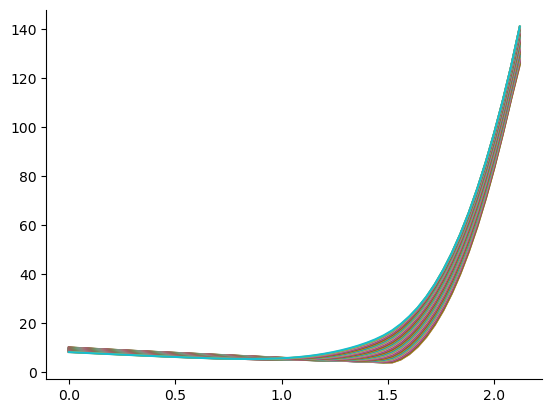

In [68]:
plt.plot(y1_grid_cap, E)
plt.show()

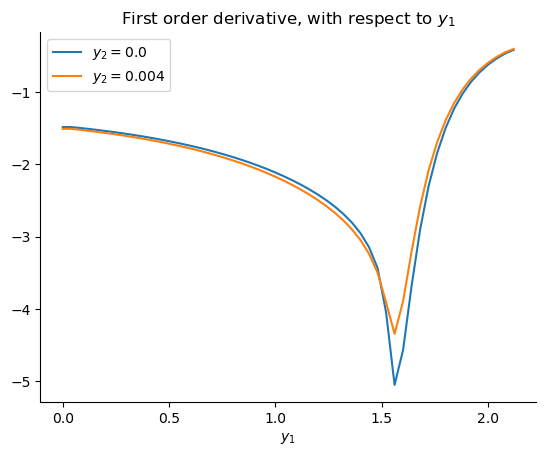

In [69]:
plt.title("First order derivative, with respect to $y_1$")
plt.plot(y1_grid_cap, dVdy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, dVdy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy1")
plt.show()

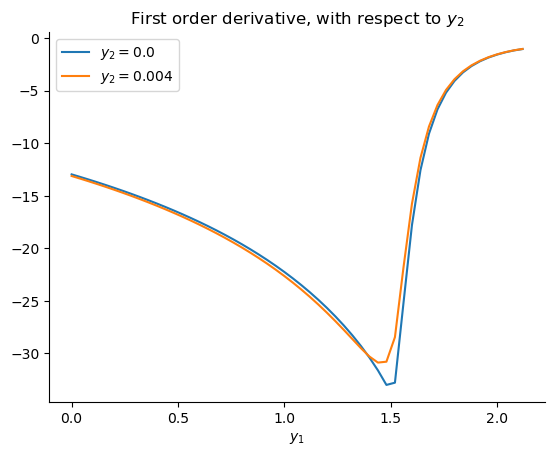

In [70]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y1_grid_cap, dVdy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, dVdy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy2")
plt.show()

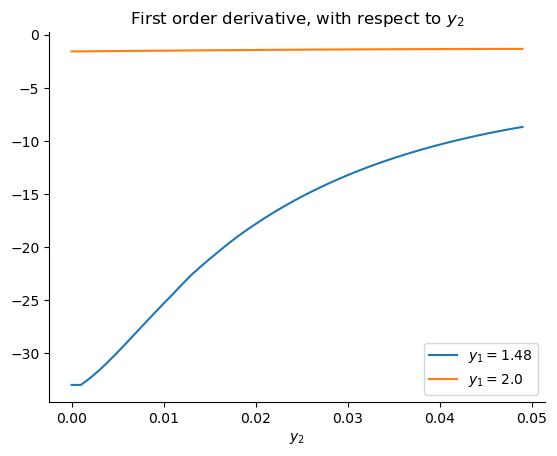

In [71]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y2_grid, dVdy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
plt.plot(y2_grid, dVdy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
plt.xlabel(r"$y_2$")
plt.legend()
# plt.savefig("dv_dy2_y2")
plt.show()

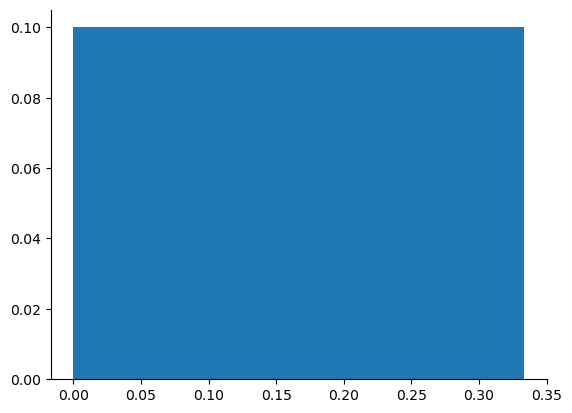

In [72]:
g_i = g_m[:, -1, 2]
plt.hist(gamma_3_list, weights= g_i/ np.sum(g_i, axis=0))
plt.show()

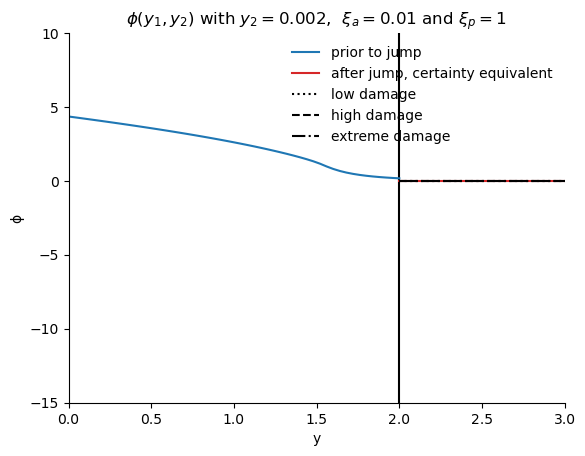

In [73]:
#
plt.plot(y1_grid[:loc_2 + 1],
         phi_mat[:loc_2 + 1, 2],
         color="tab:blue",
         label="prior to jump")
plt.plot(y1_grid[loc_2:],
         ϕ_equiv[loc_2:][:, 2],
         color="tab:red",
         label="after jump, certainty equivalent")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle=":",
         label="low damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle="--",
         label="high damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle="-.",
         label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 0.01$ and $ξ_p = 1$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15, 10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

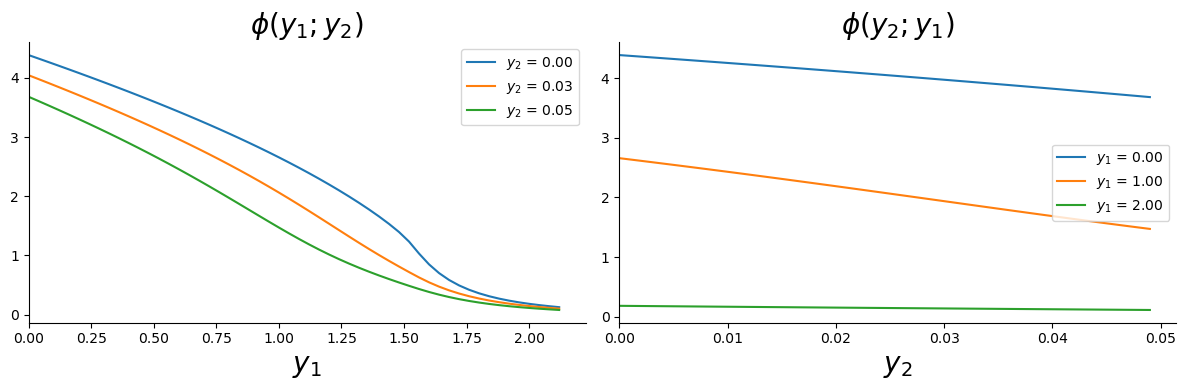

In [74]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], V[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], V[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], V[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], V[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1 / 4)], V[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1 / 2)], V[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
# ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

In [75]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, E, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    E_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, E, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = theta*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        E_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        E_t[t] = E_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - lambda0*y2 + lambda0*theta*E_point)*dt
    return Y1t, Y2t, E_t

In [76]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
#         y2_0 = max(y2_0, 0)
#         y2_0 = min(y2_0, 0.05)
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = np.exp(-λ)*y2_0 + (1 - np.exp(-λ))*θ*Et[i] 
#         y2_0 = max(y2_0, 0)
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [77]:
et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                  y2_grid,
                                                  E,
                                                  lambda0,
                                                  np.mean(theta_list),
                                                  y1_0 = 1.1,
                                                  y2_0=np.mean(theta_list),
                                                  T=93
                                                 )

In [78]:
simul = {
    "et": et_prejump,
    "y1t": y1t_prejump,
    "y2t": y2t_prejump,
}

pickle.dump(simul, open("simul_2", "wb"))

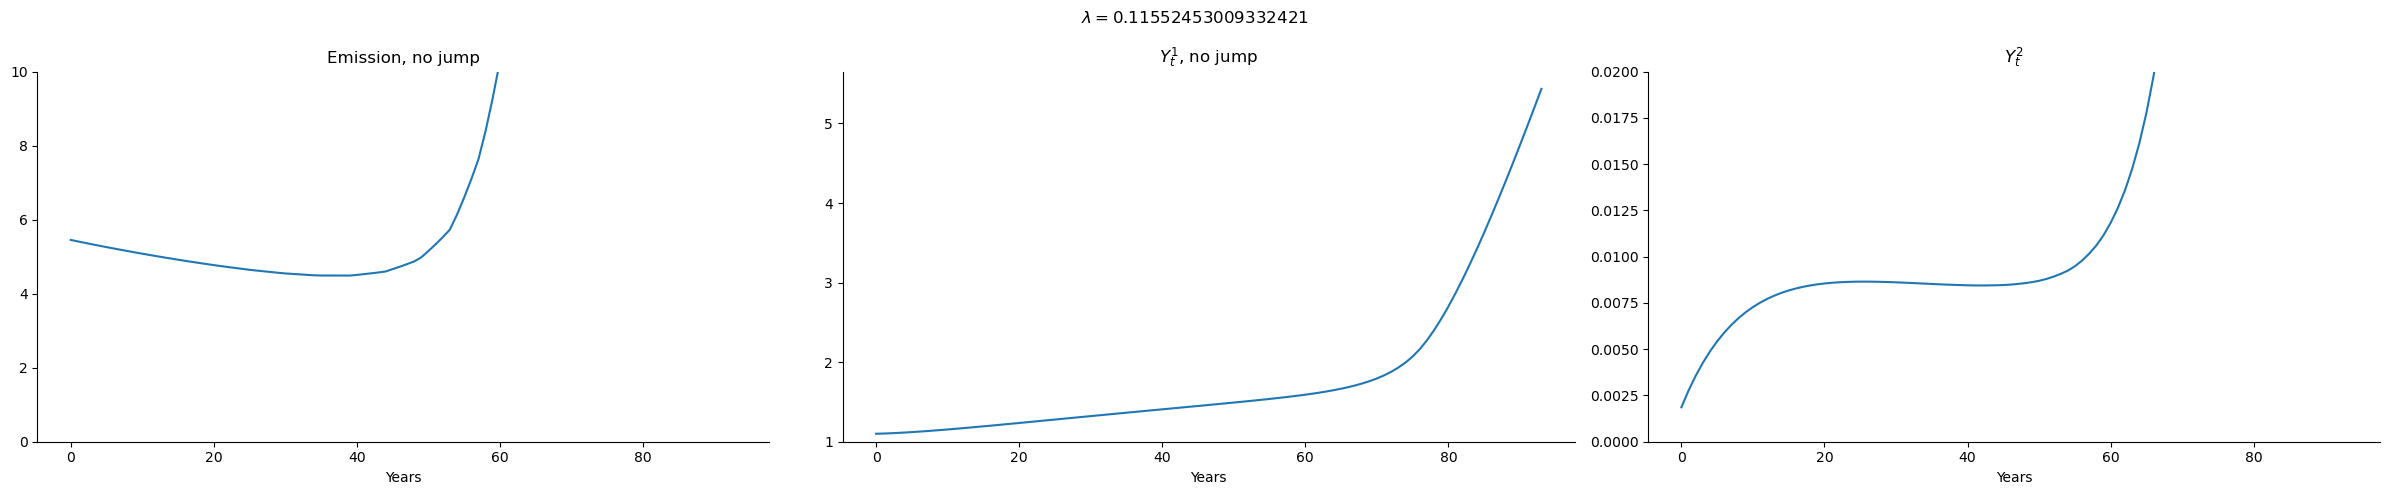

In [79]:
fig = plt.figure(figsize=(24, 5))
fig.suptitle(f"$\lambda = {lambda0}$")
plt.subplot(131)
plt.title("Emission, no jump")
plt.plot(et_prejump)
plt.ylim(0,10)
plt.xlabel("Years")
plt.subplot(132)
plt.xlabel("Years")
plt.title(r"$Y_t^1$, no jump")
plt.plot(y1t_prejump)
plt.ylim(1)
plt.subplot(133)
plt.title(r"$Y_t^2$")
plt.plot(y2t_prejump)
plt.ylim(0, 0.02)
plt.xlabel("Years")
plt.tight_layout()
# plt.savefig(f"e_y1_y2_{λ}")
plt.show()